In [1]:
import pandas as pd 
from sqlalchemy import create_engine
import matplotlib.pyplot as plt  
import numpy as np
from scipy import stats
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from scipy.stats import norm
import time
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy import create_engine
import xgboost as xgb


pd.set_option('display.max_columns', 500)

### Retrieve sample data

In [2]:
import pickle
df = pickle.load(open('../back_test_sample.sav', 'rb'))
df = df.loc[df.date >= datetime.datetime(2018,1,1,0,0).timestamp()].sort_values(['date'], ascending=True)
last_row = 0
for index, row in df.dropna().iterrows():
    ok = True
    if last_row == 0:
        last_row = row['date']
        continue
    if row['date'] - last_row  != 14400:
        print('Not consistent')
        print(row.date)
        print(last_row)
    #df.loc[df.index==index, 'dif'] = row['date'] - last_row 
    last_row = row['date']
#df[['date', 'dif']]

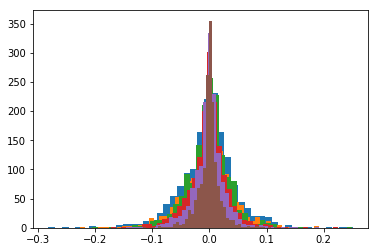

In [3]:
plt.hist(df.target_log_return_6, bins=45)
plt.hist(df.target_log_return_5, bins=45)
plt.hist(df.target_log_return_4, bins=45)
plt.hist(df.target_log_return_3, bins=45)
plt.hist(df.target_log_return_2, bins=45)
plt.hist(df.target_log_return_1, bins=45)
plt.show()

### Separate features and target variables
    - additionaly we define the probability of a non-good target hit stop loss and a good target to hit stop loss are calulated

In [4]:
def get_x_y(target_value, features_df):
    targets = ['target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6',]
    
    mask = (
       ((features_df['target_log_return_1'] >= target_value)
        | (features_df['target_log_return_2'] >= target_value) 
        | (features_df['target_log_return_3'] >= target_value) 
        | (features_df['target_log_return_4'] >= target_value)
        | (features_df['target_log_return_5'] >= target_value)
        | (features_df['target_log_return_6'] >= target_value))
           )
    features_df.loc[mask, 'target_sign'] = 1
    features_df.loc[~mask, 'target_sign'] = 0
    
    drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
                'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6'
               ]

    # Preparing dataframe
    clean_df = features_df.drop(drop_columns, axis=1).copy()
    # Defining Features (X) and Target Variable (y)
    
    returns = []
    for t in targets:
        returns.append(features_df.loc[features_df['target_sign'] == 0][t].values)

    flat_missed_list = [item for sublist in returns for item in sublist if not math.isnan(item)]

    returns = []
    for t in targets:
        returns.append(features_df.loc[features_df['target_sign'] == 1][t].values)

    flat_list = [item for sublist in returns for item in sublist if not math.isnan(item)]
    
    
    X = clean_df.drop(['target_sign'], axis =1)
    y = clean_df[['target_sign']]
    
    return X, y, flat_missed_list, flat_list
    
    

### Running model

In [5]:
def run_model(X_sample, y_sample, target_value, threshold,  model, scale=True, smote=True):
    
    if scale:
        scaler = MinMaxScaler().fit(X_sample)
        X_sample = scaler.transform(X_sample)
    # Split Train, Test
    X_train, X_test = X_sample[:math.floor(len(X_sample) * 0.75)], X_sample[math.ceil(len(X_sample) * 0.75):]
    y_train, y_test = y_sample.iloc[:math.floor(len(y_sample) * 0.75)], y_sample.iloc[math.ceil(len(y_sample) * 0.75):]

    if smote:
        # Rebalance Samples
        oversampler = SMOTE(random_state=42)
        X_train, y_train = oversampler.fit_sample(X_train, y_train.target_sign)
        
    # (Re) define Models
    model.fit(X_train, y_train)
    predicted_proba = model.predict_proba(X_test)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    precision = precision_score(y_test, predicted)
    train_acc = accuracy_score(y_test, predicted)
    return {
        'Precision': precision,
        'Accuracy': train_acc,
        'Trades': np.sum(predicted),
        'Real Profits': np.sum(y_test)[0],
        'Target': target_value,
        'Scaler': scaler,
        'Model': model
    }

### For a given stop loss-take profit value, we define de Expected Return of the model:
    - Sum of the given values:
        - Precision of the model is right * Probability of not hitting stop loss mark * Take Profit
        - Precision of the model is right * Probability of hitting stop loss mark * Stop Loss
        - Precision of the model is wrong * Probability of not hitting stop loss mark * Mean Return of Sample
        - Precision of the model is wrong * Probability of hitting stop loss mark * Stop Loss

In [9]:
def estimate_best_stop_loss(flat_missed_list, flat_list, TP, P):
    risk_free = ((1 + 0.065) ** (1/252) - 1)
    simulations = []
    ps = 0.05
    while ps < 1:
        SL = np.percentile(flat_missed_list, ps*100)
        if SL < - 4 * TP or SL > -0.01 :
            ps += 0.05
            continue
        P_stop_loss_right = len([f for f in flat_list if f <= SL])/len(flat_list)
        Mean_return_wrong = np.percentile(flat_missed_list, 10)
        ER = P * (1 - P_stop_loss_right) * TP + P * P_stop_loss_right * SL + (1 - P) * (1 - ps) * Mean_return_wrong  + (1 - P) * ps * SL
        simulations.append({
            'ER': ER,
            'Probability Stop Loss Miss': ps,
            'Probability Stop Loss Right': P_stop_loss_right,
            'Stop_Loss': SL,
            'Multiple': ER/risk_free,
            'Precision': P,
            'Take_profit': TP
        })
        ps += 0.05
    return sorted(simulations, key = lambda i: i['ER'], reverse=True)[0]
    

### For a given Size of Sample to use in model each step we do the following:
     - Run the model (if enough sample)
     - Select best parameters (Stop Loss and Take Profit)
     - Predict (if Model is good enough)
    

In [ ]:
training_window = 75 # days
sample_model = training_window * (86400/14400)

target_values = [0.01, 0.0125, 0.015, 0.0175, 0.02]
threshold = 0.75
risk_free = ((1 + 0.065) ** (1/252) - 1)

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Extra Tree': ExtraTreesClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boost': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(max_depth=8, learning_rate=0.1, n_estimators=300,
                        objective= "binary:logistic", eval_metric="error", gamma=0.,  #map
                        max_delta_step=5, subsample=0.8, colsample_bytree=0.4,
                        seed=0, )  
}

drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
                'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6'
               ]


back_test = df.copy()
for index, row in back_test.iterrows():
    signal = 0
    current_date = row['date']
    base_date = current_date - training_window * 6 * 14400
    model_sample = back_test.loc[(back_test.date < current_date)].copy()
    if len(model_sample) < sample_model:
        continue
    
    best_model = {'ER': risk_free, 'Model': None}
    for target_value in target_values:
        X, y, flat_missed_list, flat_list = get_x_y(target_value, model_sample)
        model = run_model(X, y, target_value, threshold, models['XGBoost'])
        df.loc[df.date == current_date, 'Model_Precision'] = model['Precision']
        if model['Precision'] < 0.5:
            continue
        best_parameters_model = estimate_best_stop_loss(flat_missed_list, flat_list, target_value, model['Precision'])
        if best_parameters_model['ER'] > best_model['ER']:
            best_model = {
                'Model': model,
                'ER': best_parameters_model['ER'],
                'Best_parameters': best_parameters_model
            }
        
    if best_model['Model'] and best_model['ER'] > risk_free: 
        X = row.drop(drop_columns)
        X = best_model['Model']['Scaler'].transform(X.ravel().reshape(1, -1))
        predicted_proba = best_model['Model']['Model'].predict_proba(X)
        if predicted_proba[0][1] > threshold:
            signal = 1
        df.loc[df.date == current_date, 'Model_ER'] = best_model['Best_parameters']['ER']
        df.loc[df.date == current_date, 'Model_TP'] = best_model['Best_parameters']['Take_profit']
        df.loc[df.date == current_date, 'Model_SL'] = best_model['Best_parameters']['Stop_Loss']
        df.loc[df.date == current_date, 'Signal'] = signal
        df.loc[df.date == current_date, 'Precision'] = best_model['Model']['Precision']

In [ ]:
has_balance = True
book = pd.DataFrame(columns=['date', 'coin', 'value'])
orders = pd.DataFrame(columns=['date', 'coin', 'quote', 'volume', 
                               'take_profit', 'stop_loss', 'status', 'exit', 'exit_quote', 'date_exit'])
book.loc[len(book)] = [df.iloc[0].date,'USDT', 100]
book.loc[len(book)] = [df.iloc[0].date,'BTC', 0]


for index, row in df.iterrows():
    balance_usdt = book.loc[book['coin'] == 'USDT'].value.sum()
    balance_btc = book.loc[book['coin'] == 'BTC'].value.sum()
    open_transactions = orders.loc[(orders['status'] == 'open')]
    
    for it, rt in open_transactions.iterrows():
        if row['close'] <= rt['stop_loss']: # SELL
            book.loc[len(book)] = [row.date,'USDT', rt['volume'] * row['close']]
            book.loc[len(book)] = [row.date,'BTC', -rt['volume']]
            orders.loc[orders.index==it, 'status'] = 'close'
            orders.loc[orders.index==it, 'exit'] = np.log(row['close']/rt['quote'])
            orders.loc[orders.index==it, 'exit_quote'] = row['close']
            orders.loc[orders.index==it, 'date_exit'] = row['date']
            
        elif row['close'] >= rt['take_profit']: # SELL
            book.loc[len(book)] = [row.date,'USDT', rt['volume'] * row['close']]
            book.loc[len(book)] = [row.date,'BTC', -rt['volume']]
            orders.loc[orders.index==it, 'status'] = 'close'
            orders.loc[orders.index==it, 'exit'] = np.log(row['close']/rt['quote'])
            orders.loc[orders.index==it, 'exit_quote'] = row['close']
            orders.loc[orders.index==it, 'date_exit'] = row['date']
            
    
    if row['Signal'] == 1:
        balance_usdt = book.loc[book['coin'] == 'USDT'].value.sum()
        if balance_usdt > 0: # CAN BUY
            size_coin = (balance_usdt/row['close'])
            orders.loc[len(orders)] = [row['date'], 'BTC', row['close'], size_coin,
                                       row['Model_TP'], row['Model_SL'], 'open', 0, np.nan, np.nan]
            book.loc[len(book)] = [row.date,'USDT', -balance_usdt]
            book.loc[len(book)] = [row.date,'BTC', size_coin]
    
            
        

In [ ]:
book.groupby(['coin']).sum()[['value']]

In [ ]:
orders['date'] = pd.to_datetime(orders['date'],unit='s')
orders['date_exit'] = pd.to_datetime(orders['date_exit'],unit='s')
orders['time_hold'] = orders['date_exit'] - orders['date']
orders

In [ ]:
len(orders.loc[orders['exit'] > 0])/len(orders)

In [ ]:
book['date'] = pd.to_datetime(book['date'],unit='s')

In [ ]:
coin_book = book.loc[(book['coin'] == 'USDT') & (book['value'] >= 0)]
plt.plot(coin_book['date'], coin_book['value'])
plt.show()

In [ ]:
dif = ((datetime.datetime.fromtimestamp(df.iloc[-1].date) - datetime.datetime(2018,3,1)).days)

In [ ]:
risk_free = ((1 + 0.065) ** (1/252) - 1)

In [ ]:
risk_free

In [ ]:
return_dif =  (book.loc[book['coin'] == 'USDT'].groupby(['coin']).sum()[['value']].values[0][0]/100 - 1)

In [ ]:
((1 + return_dif) ** (365/dif) - 1)

In [ ]:
0.065

In [ ]:
plt.plot(df.date, df.Model_Precision)
plt.show()

In [55]:
target_value = 0.015
threshold = 0.5
risk_free = ((1 + 0.065) ** (1/252) - 1)

models = {
    'XGBoost': xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400,
                        objective= "binary:logistic", eval_metric="error", gamma=0.,  #map
                        max_delta_step=5, subsample=0.9, colsample_bytree=0.4,
                        seed=0, )  
}


back_test = df.copy().sort_values('date')
X, y, flat_missed_list, flat_list = get_x_y(target_value, back_test.iloc[:-50])
model = run_model(X, y, target_value, threshold, models['XGBoost'], scale=True, smote=True)
model

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


{'Accuracy': 0.6089238845144357,
 'Model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.4, eval_metric='error', gamma=0.0,
        learning_rate=0.05, max_delta_step=5, max_depth=6,
        min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
        nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
        subsample=0.9),
 'Precision': 0.46153846153846156,
 'Real Profits': 140.0,
 'Scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'Target': 0.015,
 'Trades': 117}

In [56]:
training_window = 75 # days
sample_model = training_window * (86400/14400)

threshold = 0.5
risk_free = ((1 + 0.065) ** (1/252) - 1)

drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
                'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6'
               ]


back_test = df.copy()
for index, row in back_test.iloc[-50:].iterrows():
    signal = 0
    current_date = row['date']
    X = row.drop(drop_columns)
    X = model['Scaler'].transform(X.ravel().reshape(1, -1))
    predicted_proba = model['Model'].predict_proba(X)
    if predicted_proba[0][1] > 0.5:
        signal = 1
    back_test.loc[back_test['date'] == row['date'], 'predicted_signal'] = signal

In [57]:
mask = (
       ((back_test['target_log_return_1'] >= target_value)
        | (back_test['target_log_return_2'] >= target_value) 
        | (back_test['target_log_return_3'] >= target_value) 
        | (back_test['target_log_return_4'] >= target_value)
        | (back_test['target_log_return_5'] >= target_value)
        | (back_test['target_log_return_6'] >= target_value))
           )
back_test.loc[mask, 'target_sign'] = 1
back_test.loc[~mask, 'target_sign'] = 0

In [58]:
results = back_test.dropna()
results.loc[(results['predicted_signal'] == 1) & (results['target_sign'] == 1), 'profit'] = target_value
results.loc[(results['predicted_signal'] == 1) & (results['target_sign'] == 0), 'profit'] = -target_value
results.loc[(results['profit'].isnull()), 'profit'] = 0

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [59]:
results.profit.sum()

0.09

In [60]:
len(results.loc[results['profit'] > 0])/(len(results.loc[results['profit'] < 0]) + len(results.loc[results['profit'] >0]))

0.875

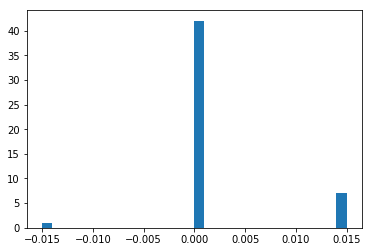

In [61]:
plt.hist(results.profit, bins=30)
plt.show()